## Iceberg retrieval fig

In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json

from ms_pred import common
from ms_pred.common import plot_utils
from ms_pred.common.plot_utils import *

set_style()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_names = ["nist20", "canopus_train_public"]
results_folder = Path("../results/figs_iceberg/retrieval")
results_folder.mkdir(exist_ok=True)


In [6]:
names = [
        "Random",
        "NEIMS (FFN)",
        "NEIMS (GNN)",
        "SCARF", 
        "ICEBERG",
    ]
dataset_to_res = {}
for dataset_name in dataset_names:
    results_files = [
        f"../results/dag_inten_{dataset_name}/split_1/retrieval_{dataset_name}/rerank_eval_random.yaml",
        f"../results/ffn_baseline_{dataset_name}/split_1/retrieval_{dataset_name}/rerank_eval_cos.yaml",
        f"../results/gnn_baseline_{dataset_name}/split_1/retrieval_{dataset_name}/rerank_eval_cos.yaml",
        f"../results/scarf_inten_{dataset_name}/split_1/retrieval_{dataset_name}/rerank_eval_cos.yaml",
        f"../results/dag_inten_{dataset_name}/split_1/retrieval_{dataset_name}/rerank_eval_cos.yaml"
    ]

    yaml_files = {i: yaml.safe_load(open(j, "r")) for i, j in zip(names, results_files)}
    dataset_to_res[dataset_name] = yaml_files

In [7]:
f1 = list(yaml_files.values())[0]
f1.keys()

dict_keys(['avg_top_1', 'avg_top_10', 'avg_top_2', 'avg_top_3', 'avg_top_4', 'avg_top_5', 'avg_top_6', 'avg_top_7', 'avg_top_8', 'avg_top_9', 'avg_total_decoys', 'avg_true_dist', 'data_folder', 'dataset', 'dist_fn', 'individuals'])

In [8]:
out_df = []
keys_to_name = {f"avg_top_{i}": i for i in range(1,11)}

for dataset, yaml_files in dataset_to_res.items():

    for k, v in yaml_files.items():
        for old_name, new_name in keys_to_name.items():
            new_entry = {
                "Method": k, 
                "Top k": new_name,
                "Acc": v[old_name],
                "Dataset": dataset
            }
            out_df.append(new_entry)
out_df = pd.DataFrame(out_df)

In [10]:

for dataset_name in dataset_names:
    # Filter out df to specific dataset 
    df = out_df[out_df["Dataset"] == dataset_name]
    pivoted_tbl = df.reset_index().pivot_table(index="Method", values="Acc", columns="Top k")
    pivoted_tbl.index.name = None
    pivoted_tbl = pivoted_tbl.round(3)
    pivoted_tbl = pivoted_tbl.loc[names]

    latex = pivoted_tbl.to_latex(caption=f"{dataset_name} spectra prediction retrieval accuracy", 
                                label=f"tab:{dataset_name}_spec_retrieval")
    print(latex)

\begin{table}
\centering
\caption{nist20 spectra prediction retrieval accuracy}
\label{tab:nist20_spec_retrieval}
\begin{tabular}{lrrrrrrrrrr}
\toprule
Top k &     1  &     2  &     3  &     4  &     5  &     6  &     7  &     8  &     9  &     10 \\
\midrule
Random      &  0.025 &  0.047 &  0.073 &  0.097 &  0.118 &  0.139 &  0.162 &  0.186 &  0.209 &  0.234 \\
NEIMS (FFN) &  0.106 &  0.233 &  0.318 &  0.378 &  0.424 &  0.465 &  0.501 &  0.532 &  0.564 &  0.592 \\
NEIMS (GNN) &  0.169 &  0.296 &  0.391 &  0.462 &  0.515 &  0.555 &  0.584 &  0.620 &  0.650 &  0.678 \\
SCARF       &  0.184 &  0.323 &  0.415 &  0.492 &  0.546 &  0.588 &  0.624 &  0.653 &  0.677 &  0.703 \\
ICEBERG     &  0.203 &  0.383 &  0.492 &  0.565 &  0.617 &  0.658 &  0.693 &  0.722 &  0.745 &  0.765 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrrrrr}
\topr

/tmp/ipykernel_791556/443961179.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(caption=f"{dataset_name} spectra prediction retrieval accuracy",
/tmp/ipykernel_791556/443961179.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(caption=f"{dataset_name} spectra prediction retrieval accuracy",


```
\begin{table}
\centering
\caption{nist20 spectra prediction retrieval accuracy}
\label{tab:nist20_spec_retrieval}
\begin{tabular}{lrrrrrrrrrr}
\toprule
Top k &     1  &     2  &     3  &     4  &     5  &     6  &     7  &     8  &     9  &     10 \\
\midrule
Random      &  0.025 &  0.047 &  0.073 &  0.097 &  0.118 &  0.139 &  0.162 &  0.186 &  0.209 &  0.234 \\
NEIMS (FFN) &  0.106 &  0.233 &  0.318 &  0.378 &  0.424 &  0.465 &  0.501 &  0.532 &  0.564 &  0.592 \\
NEIMS (GNN) &  0.169 &  0.296 &  0.391 &  0.462 &  0.515 &  0.555 &  0.584 &  0.620 &  0.650 &  0.678 \\
SCARF       &  0.184 &  0.323 &  0.415 &  0.492 &  0.546 &  0.588 &  0.624 &  0.653 &  0.677 &  0.703 \\
ICEBERG     &  0.203 &  0.383 &  0.492 &  0.565 &  0.617 &  0.658 &  0.693 &  0.722 &  0.745 &  0.765 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrrrrr}
\toprule
Top k &     1  &     2  &     3  &     4  &     5  &     6  &     7  &     8  &     9  &     10 \\
\midrule
Random      &  0.021 &  0.053 &  0.087 &  0.114 &  0.137 &  0.151 &  0.180 &  0.205 &  0.225 &  0.241 \\
NEIMS (FFN) &  0.212 &  0.330 &  0.412 &  0.469 &  0.510 &  0.543 &  0.569 &  0.590 &  0.613 &  0.636 \\
NEIMS (GNN) &  0.187 &  0.302 &  0.370 &  0.427 &  0.470 &  0.514 &  0.550 &  0.586 &  0.613 &  0.635 \\
SCARF       &  0.112 &  0.233 &  0.320 &  0.369 &  0.425 &  0.470 &  0.515 &  0.552 &  0.582 &  0.613 \\
ICEBERG     &  0.312 &  0.466 &  0.538 &  0.603 &  0.648 &  0.675 &  0.704 &  0.732 &  0.754 &  0.768 \\
\bottomrule
\end{tabular}
\end{table}





```

In [15]:
method_names = ["Random", "NEIMS (FFN)", "NEIMS (GNN)", "SCARF", "ICEBERG"]

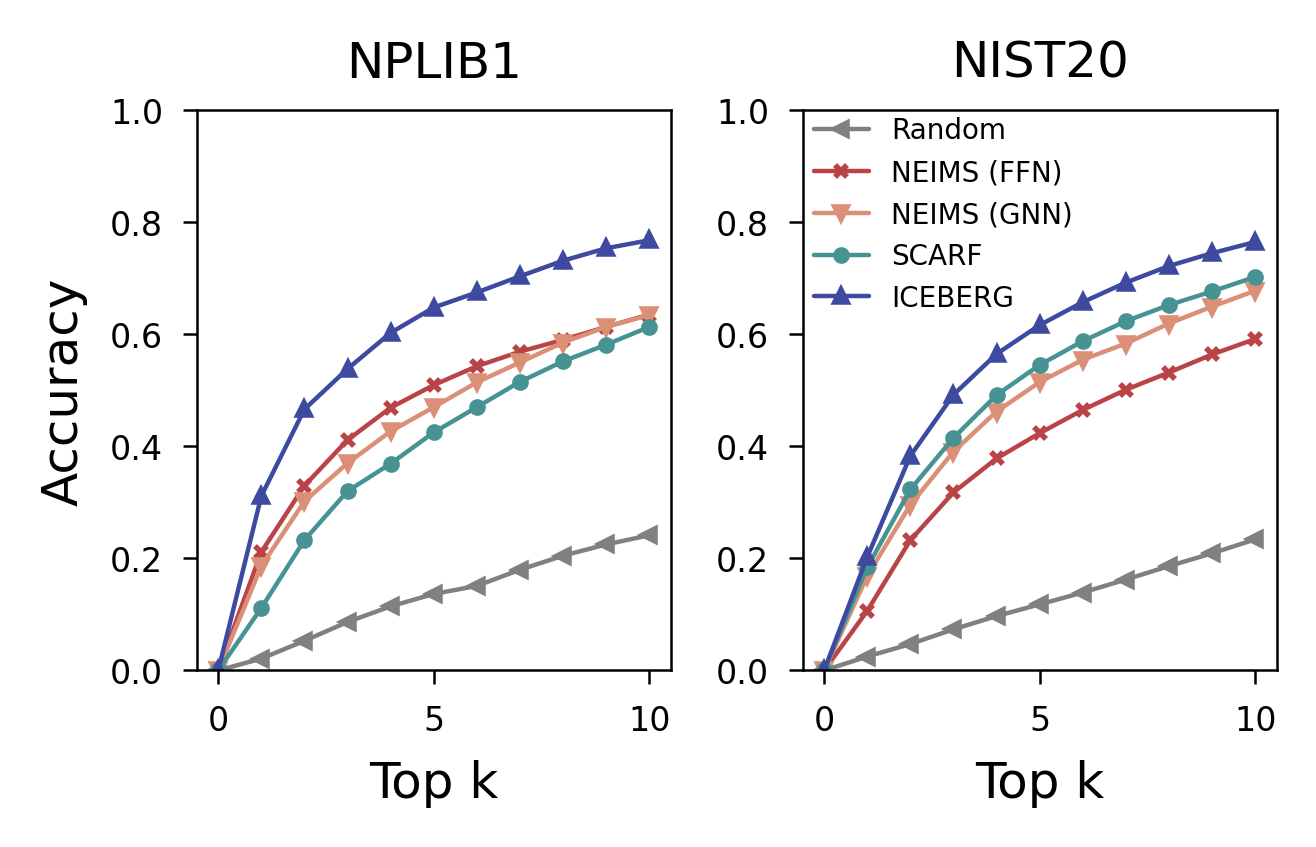

In [42]:

# List all markers for lineplot matplotlib in a comment
# markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]


method_markers = dict(zip(method_names, ["<", "x", "v", "o", "^"]))


# Define plot title dataset names mapping as dict
plt_dataset_names = {"canopus_train_public": "NPLIB1", "nist20": "NIST20"}



# Define 2 axes for fig subplot

figsize = (2.7, 1.4)
gridspec = dict(hspace=0.0, width_ratios=[1, 0.01, 1])
fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=400, sharey=False, 
                         gridspec_kw=gridspec)

axes[1].set_visible(False)
loop_ax = [axes[0], axes[2]]
for ind, (dataset_name, ax) in  enumerate(zip(["canopus_train_public", "nist20"], loop_ax)):
    for method in method_names:

        # Subset df by method and dataset
        sub_df = out_df[(out_df["Method"] == method) & (out_df["Dataset"] == dataset_name)]
        topk = [0] + sub_df['Top k'].values.tolist()
        accs = [0] + sub_df['Acc'].values.tolist()
        # ax.step(topk, accs, color=method_colors[method],
        #         linewidth=0.8, where="pre"
        # )
        marker = method_markers[method]
        ax.plot(topk, accs, color=method_colors[method],
                linewidth=0.8, label=method, marker=marker,
                markersize=2
        )
        # set title
        ax.set_title(plt_dataset_names[dataset_name])
        

    ax.set_xlabel("Top k")
    if ind == 0:
        ax.set_ylabel("Accuracy")
# ax.set_xlim([-0.1,5.1])
# ax.set_ylim([0, 0.3])
    if ind == 1: 
        ax.legend(frameon=False, facecolor="none", fancybox=False,loc=(0.0, 0.62), fontsize=5) #(0.99, 0.5))
    ax.set_ylim([0, 1.0])
set_size(*figsize, ax)
fig.savefig(results_folder / f"step_plot.pdf", dpi=400, bbox_inches="tight", 
            transparent=True)


In [21]:
scarf_inds = yaml_files['SCARF']['individuals']
gnn_inds = yaml_files['NEIMS (GNN)']['individuals']
scarf_spec_to_ind = {i['spec_name']: i['ind_recovered'] for i in scarf_inds}
gnn_spec_to_ind = {i['spec_name']: i['ind_recovered'] for i in gnn_inds}

In [22]:
scarf_better = [k for k, v in scarf_spec_to_ind.items() if v == 1 and v < gnn_spec_to_ind[k]]